In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
sys.path.append("../")
from utils import *
from tqdm import tqdm
import math
import json
import pickle
import os, sys
import re
from scipy.sparse import csr_matrix, coo_matrix
from scipy.stats import norm

In [6]:
# dataMp0 = LoadInSnnOutputData("../layer_record_CIFAR10DVS/mp.L3.conv.plif.csv", 0, 100, 100, unmerge=True)
dataOut0 = LoadInSnnOutputData("../layer_record_CIFAR10DVS/output.L2.conv.plif.csv", 0, 100, 100, unmerge=True)
# dataOut0 = LoadInSnnOutputData("../layer_record_IMAGENET/output.L2.conv.plif.csv", 0, 100, 100, unmerge=True)

# print(f"dataMp0.shape = {dataMp0.shape}")
print(f"dataOut0.shape = {dataOut0.shape}")

print(f"sparse rate of dataOut0 = {np.sum(dataOut0==0)/dataOut0.size}")

dataOut0.shape = (100, 4096, 128)
sparse rate of dataOut0 = 0.8925565719604492


# 1. 动态步长前期实验评估

mp中保存着不同time step的膜电位，output保存着最终spike输出。
这个实验是探索通过膜电位能否有效的动态控制merge timestep。

## 1. output spike时空稀疏性

In [ ]:
np.min(dataOut0[0, :128, :])

In [ ]:
# 空间局部性
# ts = 2
# plt.imshow(dataOut0[ts, :100, :], cmap='binary')
# print(f"spatial sparse rate of dataOut0 = {np.sum(dataOut0[0, :128, :]==0)/dataOut0[0, :128, :].size}")

# 创建一个图形和轴
fig, ax = plt.subplots()

# 初始化一个用于动画的二维图像
img = ax.imshow(dataOut0[0, :100, :], cmap='binary')

def update(frame):
    # 更新图像数据
    img.set_data(dataOut0[frame, :100, :])
    return [img]

# 创建动画
ani = FuncAnimation(fig, update, frames=range(dataOut0.shape[0]), interval=100, blit=True)

# 显示动画
from IPython.display import HTML
HTML(ani.to_jshtml())
# HTML(ani.to_html5_video())
# ani.save('spike_spatial_sparsity.mp4')

In [ ]:
plt.imshow(dataMp0[ts, :100, :], cmap='Greys', vmin=0, vmax=1)

In [ ]:
# 时间局部性
from sympy import intervals


row_loc = 3
# plt.imshow(dataOut0[:, row_loc, :], cmap='binary')
# print(f"temporal sparse rate of dataOut0 = {np.sum(dataOut0[:, 0, :]==0)/dataOut0[:, 0, :].size}")

# 创建一个图形和轴
fig, ax = plt.subplots()

# 初始化一个用于动画的二维图像
img = ax.imshow(dataOut0[:, 0, :], cmap='binary')

def update(frame):
    # 更新图像数据
    img.set_data(dataOut0[:, frame, :])
    return [img]

# 创建动画
ani = FuncAnimation(fig, update, frames=range(100), interval=200, blit=True)

# 显示动画
from IPython.display import HTML
HTML(ani.to_jshtml())
# HTML(ani.to_html5_video())
# ani.save('spike_temporal_sparsity.mp4')


In [ ]:
# plt.imshow(dataMp0[:, row_loc, :], cmap='Reds', vmin=0, vmax=1)
# 时间局部性
from sympy import intervals


row_loc = 3
# plt.imshow(dataOut0[:, row_loc, :], cmap='binary')
# print(f"temporal sparse rate of dataOut0 = {np.sum(dataOut0[:, 0, :]==0)/dataOut0[:, 0, :].size}")

# 创建一个图形和轴
fig, ax = plt.subplots()

# 初始化一个用于动画的二维图像
img = ax.imshow(dataMp0[:, 0, :], cmap='Reds', vmax=1, vmin=0)

def update(frame):
    # 更新图像数据
    img.set_data(dataMp0[:, frame, :])
    return [img]

# 创建动画
ani = FuncAnimation(fig, update, frames=range(100), interval=100, blit=True)

# 显示动画
from IPython.display import HTML
HTML(ani.to_jshtml())
# HTML(ani.to_html5_video())
# ani.save('spike_temporal_sparsity.mp4')

In [116]:
import random


dataOut0_1 = LoadInSnnOutputData("/root/spikingjelly/PyNeuroSim/layer_record_CIFAR10DVS_label_0_1/output.L4.conv.plif.csv", 0, 100, 100, unmerge=True)
dataOut0_2 = LoadInSnnOutputData("/root/spikingjelly/PyNeuroSim/layer_record_CIFAR10DVS_label_0_2/output.L4.conv.plif.csv", 0, 100, 100, unmerge=True)
dataOut1_1 = LoadInSnnOutputData("/root/spikingjelly/PyNeuroSim/layer_record_CIFAR10DVS_label_1_1/output.L4.conv.plif.csv", 0, 100, 100, unmerge=True)
dataOut1_2 = LoadInSnnOutputData("/root/spikingjelly/PyNeuroSim/layer_record_CIFAR10DVS_label_1_2/output.L4.conv.plif.csv", 0, 100, 100, unmerge=True)
color_bar2 = ["#2a9d8f", "#F6BD60", "#457b9d", "#F07167", "#BFA6A2", "#A1CD5A", "#ED7D31"]

In [80]:
data_in = dataOut0_1
data = np.transpose(data_in, (1, 2, 0)) # input, neuron, time
dense_rate = np.sum(data, axis=2) / data.shape[2]
print(dense_rate.shape)
k = 10
# find top-k dense neurons for each input
top_k_dense_neurons0_1 = np.argsort(dense_rate, axis=1)[:,-k:]

(256, 128)


In [81]:
data_in = dataOut0_2
data = np.transpose(data_in, (1, 2, 0)) # input, neuron, time
dense_rate = np.sum(data, axis=2) / data.shape[2]
print(dense_rate.shape)
k = 10
# find top-k dense neurons for each input
top_k_dense_neurons0_2 = np.argsort(dense_rate, axis=1)[:,-k:]


(256, 128)


In [82]:
data_in = dataOut1_1
data = np.transpose(data_in, (1, 2, 0)) # input, neuron, time
dense_rate = np.sum(data, axis=2) / data.shape[2]
print(dense_rate.shape)
k = 10
# find top-k dense neurons for each input
top_k_dense_neurons1_1 = np.argsort(dense_rate, axis=1)[:,-k:]


(256, 128)


In [83]:
data_in = dataOut1_2
data = np.transpose(data_in, (1, 2, 0)) # input, neuron, time
dense_rate = np.sum(data, axis=2) / data.shape[2]
print(dense_rate.shape)
k = 10
# find top-k dense neurons for each input
top_k_dense_neurons1_2 = np.argsort(dense_rate, axis=1)[:,-k:]


(256, 128)


In [84]:
from scipy.spatial import distance
# 计算top_k_dense_neurons0_1和top_k_dense_neurons0_2的Jaccard相似度
print(distance.jaccard(top_k_dense_neurons0_1.flatten(), top_k_dense_neurons0_2.flatten()))
print(distance.jaccard(top_k_dense_neurons0_1.flatten(), top_k_dense_neurons1_1.flatten()))

0.95625
0.9890625


## valid seed
3461043366
732374391
2969768878
633841190

Current NumPy random seed: 938346856


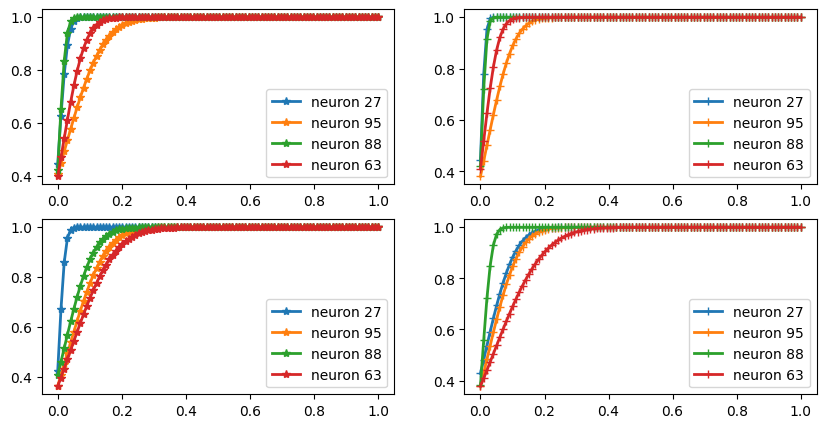

In [179]:
# seed = 2027
# seed = 2024
# np.random.seed(seed)
random_state = np.random.get_state()
random_seed = random_state[1][0]
print("Current NumPy random seed:", random_seed)
neuron_num = 4
random_neurons = np.random.choice(dataOut0_1.shape[2], neuron_num, replace=False)
## 静态时间+空间局部性特征展示
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
data_in = dataOut0_1
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']
for idx, neuron in enumerate(random_neurons):
    data = np.transpose(data_in[:, :, neuron], (1, 0)) # 时间维度有限
    data_size = data.size
    # print(data.shape)
    dense_rate = np.sum(data, axis=1) / data.shape[1]
    x = np.linspace(0, 1, 100)
    cdf = norm.cdf(x, loc=np.mean(dense_rate), scale=np.std(dense_rate))
    axs[0, 0].plot(x, cdf, label=f"neuron {neuron}", linewidth=2, marker='*')
axs[0, 0].legend()

data_in = dataOut0_2
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']
for idx, neuron in enumerate(random_neurons):
    data = np.transpose(data_in[:, :, neuron], (1, 0)) # 时间维度有限
    data_size = data.size
    # print(data.shape)
    dense_rate = np.sum(data, axis=1) / data.shape[1]
    x = np.linspace(0, 1, 100)
    cdf = norm.cdf(x, loc=np.mean(dense_rate), scale=np.std(dense_rate))
    axs[0, 1].plot(x, cdf, label=f"neuron {neuron}", linewidth=2, marker='+')
axs[0, 1].legend()
    
data_in = dataOut1_1
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']
for idx, neuron in enumerate(random_neurons):
    data = np.transpose(data_in[:, :, neuron], (1, 0)) # 时间维度有限
    data_size = data.size
    # print(data.shape)
    dense_rate = np.sum(data, axis=1) / data.shape[1]
    x = np.linspace(0, 1, 100)
    cdf = norm.cdf(x, loc=np.mean(dense_rate), scale=np.std(dense_rate))
    axs[1, 0].plot(x, cdf, label=f"neuron {neuron}", linewidth=2, marker='*')
axs[1, 0].legend()

data_in = dataOut1_2
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']
for idx, neuron in enumerate(random_neurons):
    data = np.transpose(data_in[:, :, neuron], (1, 0)) # 时间维度有限
    data_size = data.size
    # print(data.shape)
    dense_rate = np.sum(data, axis=1) / data.shape[1]
    x = np.linspace(0, 1, 100)
    cdf = norm.cdf(x, loc=np.mean(dense_rate), scale=np.std(dense_rate))
    axs[1, 1].plot(x, cdf, label=f"neuron {neuron}", linewidth=2, marker='+')

axs[1, 1].legend()
    

# 2. 调度策略

从上面可以看出：

- 神经元的输出脉冲无论是时间还是空间上都存在很大的稀疏性，且空间稀疏度大于时间稀疏度
- 同一个神经元的输出脉冲还存在时间局部性和空间局部性，因此可以得到充分利用
    - 时间局部性指的同一个神经元对于同一个感知域在时间维度上存在相似的脉冲激发频率
    - 空间局部性指的是同一个神经元对于不同感知域在同一个时间步/时间维度上存在相似的脉冲激发频率

调度策略：

- 直接全局固定步长
- 直接为每一个神经元在时间维度上动态学习步长
- 直接为每一个神经元在时间+空间维度上动态学习步长
- 增加膜电位调节步长（从以上结果来看效果有限）

## 调度策略一

In [72]:
def calculateLatencyS0(data, vis=False):
    latency = data.size
    return latency

def calculateLatencyS1(data, vis=False):
    mergedTimesteps = range(1, dataOut0.shape[0] + 1, 1)
    optLatencys = []
    hitRates = []
    for mergedTimestep in tqdm(mergedTimesteps):
        assert mergedTimestep >= 1
        mergedLatency = math.ceil(math.log2(mergedTimestep + 1))
        # data的维度顺序为：T, HxW, Cout
        totalTimesteps, inputSize, outputSize = data.shape

        # vanillaLatency = totalTimesteps * inputSize * outputSize
        optLatency = 0
        hits = 0
        total = 0
        for ts in range(0, totalTimesteps, mergedTimestep):    # 遍历时间维度
            effectiveTs = min(mergedTimestep, totalTimesteps - ts)
            mergedData = np.sum(data[ts:ts+effectiveTs, :, :], axis=0)
            # 计算将合并后的数据映射到crossbar上的计算延迟
            optLatency += mergedLatency * inputSize * outputSize    # SFF延迟
            hits += np.sum(mergedData == 0)
            total += mergedData.size
            if effectiveTs > 1:
                optLatency += np.sum((mergedData > 0) * effectiveTs)   # CCR延迟
        optLatencys.append(optLatency)
        hitRates.append(hits / total)
    bestOptLatency = min(optLatencys)
    bestOptLatencyIndex = optLatencys.index(bestOptLatency)
    bestMergedSteps = mergedTimesteps[bestOptLatencyIndex]

    if vis == True:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        ln1 = plt.plot(mergedTimesteps, optLatencys, label="optLatency", color='r', marker='*')
        plt.ylabel("optLatency")
        optLatency = min(optLatencys)
        optMergedSteps = mergedTimesteps[np.argmin(optLatencys)]
        ln2 = plt.plot([optMergedSteps, optMergedSteps], [optLatency, optLatency], color='g', marker='o', label=f"({optMergedSteps}, {optLatency:.2e})")

        plt.twinx()
        ln3 = plt.plot(mergedTimesteps, hitRates, label="hitRate", color='b', marker='+')
        lengends = ln1 + ln2 + ln3
        labels = [l.get_label() for l in lengends]
        plt.legend(lengends, labels)
        plt.xlabel("mergedTimesteps")
    
    return bestMergedSteps, bestOptLatency


In [76]:
latS0 = calculateLatencyS0(dataOut0, vis=True)
print(f"Latency of S0: {latS0:.2e}")

Latency of S0: 5.24e+07


100%|██████████| 100/100 [00:04<00:00, 21.89it/s]


bestIdx = 25, bestLat = 3.65e+07


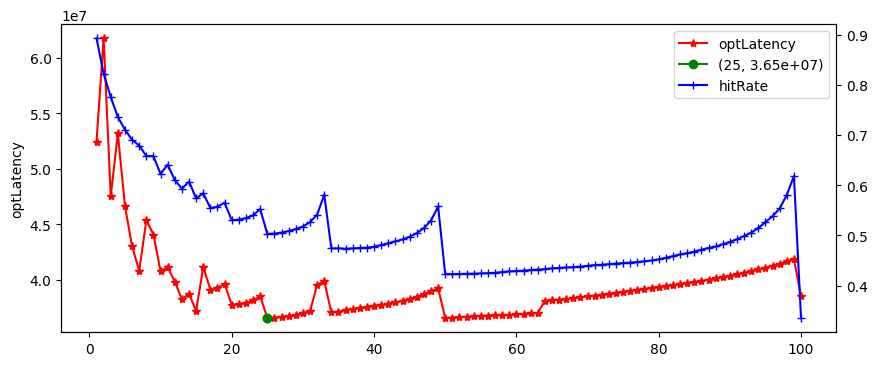

In [8]:
bestIdx, bestLat = calculateLatencyS1(dataOut0, vis=True)
print(f"bestIdx = {bestIdx}, bestLat = {bestLat:.2e}")

## 调度策略二

In [9]:
def calculateLatencyS2(data, initMergeTimestepsIndex=3, hitThreshold=2, missThreshold=1):
    totalTimesteps, inputSize, outputSize = data.shape
    logStep = math.floor(math.log2(totalTimesteps + 1))
    possible_steps = [2**i-1 for i in range(1, logStep + 1, 1)]
    possible_steps += [totalTimesteps, totalTimesteps // 2]
    possible_steps = sorted(list(set(possible_steps)))
    # vanillaLatency = totalTimesteps * inputSize * outputSize
    optLatency = 0
    mergedStepsRecord = []
    # 对每个输出神经元分别处理
    for inputIndex in tqdm(range(inputSize)):
        for neuron in range(outputSize):
            # mergedStepsIndex = initMergeTimestepsIndex    # 初始合并时间步数设置
            mergedStepsIndex = len(possible_steps) - 1
            ts = 0
            hit = 0
            miss = 0
            # 当前神经元的TW数据合并
            while ts < totalTimesteps:
                try:
                    mergedSteps = min(possible_steps[mergedStepsIndex], totalTimesteps - ts)
                    mergedStepsRecord.append(mergedStepsIndex)
                except:
                    print(mergedStepsIndex)
                    print(possible_steps)
                    raise ValueError
                mergedData = np.sum(data[ts:ts+mergedSteps, inputIndex, neuron], axis=0)
                optLatency += math.ceil(math.log2(mergedSteps + 1))
                if np.sum(mergedData) > 0: # 投机失败
                    if mergedSteps > 1 and mergedSteps != totalTimesteps:   
                        optLatency += mergedSteps
                        ts += mergedSteps
                        miss += 1
                    elif mergedSteps == totalTimesteps:     # 如果是最长时间步，不需要计算CCR延迟，从当前时间步继续尝试initMergeTimestepsIndex
                        # 根据mergedData的稀疏性，调整合适的合并时间步数
                        tmp = 100 / mergedData
                        # finde the nearest step in possible_steps
                        try:
                            mergedStepsIndex = possible_steps.index([i for i in possible_steps if (i <= tmp)][-1])
                            if mergedStepsIndex == possible_steps.index(totalTimesteps):
                                mergedStepsIndex = possible_steps.index(totalTimesteps // 2)
                        except:
                            print(tmp)
                            print(mergedData)
                            raise ValueError
                        hit = 0
                        miss = 0
                    elif mergedSteps == 1:
                        ts += mergedSteps
                        miss += 1
                    else:
                        raise ValueError
                else:
                    hit += 1
                    ts += mergedSteps
                if hit >= hitThreshold:
                    if mergedStepsIndex < len(possible_steps) - 1:
                        mergedStepsIndex += 1
                    hit = 0
                    miss = 0
                if miss >= missThreshold:
                    if mergedStepsIndex > 0:
                        mergedStepsIndex -= 1
                    hit = 0
                    miss = 0
    return optLatency, mergedStepsRecord


In [10]:
optLatency, mergedStepsRecord = calculateLatencyS2(dataOut0)
print(f"optLatency = {optLatency:.2e}")
# plt.plot(mergedStepsRecord[:1000])
# plt.hist(mergedStepsRecord, bins=20)

100%|██████████| 4096/4096 [02:15<00:00, 30.15it/s]

optLatency = 3.61e+07


## 调度策略三

In [11]:
def calculateLatencyS3(data, initMergeTimestepsIndex=3, hitThreshold=2, missThreshold=1):
    totalTimesteps, inputSize, outputSize = data.shape
    logStep = math.floor(math.log2(totalTimesteps + 1))
    possible_steps = [2**i-1 for i in range(1, logStep + 1, 1)]
    possible_steps += [totalTimesteps, totalTimesteps // 2]
    possible_steps = sorted(list(set(possible_steps)))
    # vanillaLatency = totalTimesteps * inputSize * outputSize
    optLatency = 0
    mergedStepsRecord = []
    learnedMergeStepsIndex = np.zeros(outputSize, dtype=int) - 1
    # 对每个输出神经元分别处理
    for inputIndex in tqdm(range(inputSize)):
        for neuron in range(outputSize):
            # mergedStepsIndex = initMergeTimestepsIndex    # 初始合并时间步数设置
            if learnedMergeStepsIndex[neuron] == -1:
                mergedStepsIndex = len(possible_steps) - 1
            else:
                mergedStepsIndex = learnedMergeStepsIndex[neuron]
            ts = 0
            hit = 0
            miss = 0
            # 当前神经元的TW数据合并
            while ts < totalTimesteps:
                try:
                    mergedSteps = min(possible_steps[mergedStepsIndex], totalTimesteps - ts)
                    mergedStepsRecord.append(mergedStepsIndex)
                except:
                    print(mergedStepsIndex)
                    print(possible_steps)
                    raise ValueError
                mergedData = np.sum(data[ts:ts+mergedSteps, inputIndex, neuron], axis=0)
                optLatency += math.ceil(math.log2(mergedSteps + 1))
                if np.sum(mergedData) > 0: # 投机失败
                    if mergedSteps > 1 and mergedSteps != totalTimesteps:   
                        optLatency += mergedSteps
                        ts += mergedSteps
                        miss += 1
                    elif mergedSteps == totalTimesteps:     # 如果是最长时间步，不需要计算CCR延迟，从当前时间步继续尝试initMergeTimestepsIndex
                        # 根据mergedData的稀疏性，调整合适的合并时间步数
                        tmp = 100 / mergedData
                        # finde the nearest step in possible_steps
                        try:
                            mergedStepsIndex = possible_steps.index([i for i in possible_steps if (i <= tmp)][-1])
                            if mergedStepsIndex == possible_steps.index(totalTimesteps):
                                mergedStepsIndex = possible_steps.index(totalTimesteps // 2)
                        except:
                            print(tmp)
                            print(mergedData)
                            raise ValueError
                        hit = 0
                        miss = 0
                    elif mergedSteps == 1:
                        ts += mergedSteps
                        miss += 1
                    else:
                        raise ValueError
                else:
                    hit += 1
                    ts += mergedSteps
                if hit >= hitThreshold:
                    if mergedStepsIndex < len(possible_steps) - 1:
                        mergedStepsIndex += 1
                    hit = 0
                    miss = 0
                if miss >= missThreshold:
                    if mergedStepsIndex > 0:
                        mergedStepsIndex -= 1
                    hit = 0
                    miss = 0
            learnedMergeStepsIndex[neuron] = mergedStepsIndex
    return optLatency, mergedStepsRecord


In [12]:
optLatency, mergedStepsRecord = calculateLatencyS3(dataOut0)
print(f"optLatency = {optLatency:.2e}")
# plt.plot(mergedStepsRecord[:1000])
# plt.hist(mergedStepsRecord, bins=20)


100%|██████████| 4096/4096 [02:07<00:00, 32.07it/s]

optLatency = 3.42e+07


## 调度策略四

In [13]:
def calculateLatencyS4(data, initMergeTimestepsIndex=4, hitThreshold=2, missThreshold=1):
    totalTimesteps, inputSize, outputSize = data.shape
    logStep = math.floor(math.log2(totalTimesteps + 1))
    possible_steps = [2**i-1 for i in range(1, logStep + 1, 1)]
    possible_steps += [totalTimesteps, totalTimesteps // 2]
    possible_steps = sorted(list(set(possible_steps)))
    # vanillaLatency = totalTimesteps * inputSize * outputSize
    optLatency = 0
    mergedStepsRecord = []
    # 对每个输出神经元分别处理
    for inputIndex in tqdm(range(inputSize)):
        for neuron in range(outputSize):
            mergedStepsIndex = initMergeTimestepsIndex    # 初始合并时间步数设置
            # mergedStepsIndex = len(possible_steps) - 1
            ts = 0
            hit = 0
            miss = 0
            # 当前神经元的TW数据合并
            while ts < totalTimesteps:
                try:
                    mergedSteps = min(possible_steps[mergedStepsIndex], totalTimesteps - ts)
                    mergedStepsRecord.append(mergedStepsIndex)
                except:
                    print(mergedStepsIndex)
                    print(possible_steps)
                    raise ValueError
                mergedData = np.sum(data[ts:ts+mergedSteps, inputIndex, neuron], axis=0)
                optLatency += math.ceil(math.log2(mergedSteps + 1))
                if np.sum(mergedData) > 0: # 投机失败
                    if mergedSteps > 1 and mergedSteps != totalTimesteps:   
                        optLatency += mergedSteps
                        ts += mergedSteps
                        miss += 1
                    elif mergedSteps == totalTimesteps:     # 如果是最长时间步，不需要计算CCR延迟，从当前时间步继续尝试initMergeTimestepsIndex
                        # 根据mergedData的稀疏性，调整合适的合并时间步数
                        tmp = 100 / mergedData
                        # finde the nearest step in possible_steps
                        try:
                            mergedStepsIndex = possible_steps.index([i for i in possible_steps if (i <= tmp)][-1])
                            if mergedStepsIndex == possible_steps.index(totalTimesteps):
                                mergedStepsIndex = possible_steps.index(totalTimesteps // 2)
                        except:
                            print(tmp)
                            print(mergedData)
                            raise ValueError
                        hit = 0
                        miss = 0
                    elif mergedSteps == 1:
                        ts += mergedSteps
                        miss += 1
                    else:
                        raise ValueError
                else:
                    hit += 1
                    ts += mergedSteps
                if hit >= hitThreshold:
                    if mergedStepsIndex < len(possible_steps) - 1:
                        mergedStepsIndex += 1
                    hit = 0
                    miss = 0
                if miss >= missThreshold:
                    if mergedStepsIndex > 0:
                        mergedStepsIndex -= 1
                    hit = 0
                    miss = 0
    return optLatency, mergedStepsRecord

In [14]:
optLatency, mergedStepsRecord = calculateLatencyS4(dataOut0)
print(f"optLatency = {optLatency:.2e}")
# plt.plot(mergedStepsRecord[:1000])
# plt.hist(mergedStepsRecord, bins=20)


100%|██████████| 4096/4096 [01:19<00:00, 51.24it/s]

optLatency = 3.54e+07


## 3. 实验结果

<!-- - CIFAR10DVS

|     	| SR     	| S1      	| S2     	| S3      	| S4      	|
|-----	|--------	|---------	|--------	|---------	|---------	|
|  L2 	| 89.8%  	|  3.52e7 	| 3.7e7  	| 3.55e7  	| 3.73e7  	|
|  L3 	|  96.8% 	|  4.11e6 	| 3.79e6 	|  3.81e6 	| 4.53e6  	|
|  L4 	| 96.9%  	| 8.74e5  	| 8.06e5 	| 8.37e5  	|  1.01e6 	| -->

In [77]:
## 遍历Resnet18+ImageNet的所有SNN-conv layer的结果
import os
import re
import numpy as np
from multiprocessing import Pool

'''
eval_res = {}

# 遍历文件夹"../layer_record_IMAGENET/"
layer_record_dir = "../layer_record_IMAGENET/"
pat = r"output.(L[0-9]+).conv.plif.csv"
for file in os.listdir(layer_record_dir):
    res = re.findall(pat, file)
    if len(res) and res[0] != "L1" and res[0] != "L18":
        print(f"file = {os.path.join(layer_record_dir, file)}")
        layer = res[0]
        dataOut = LoadInSnnOutputData(os.path.join(layer_record_dir, file), 0, 100, 100, unmerge=True)
        sparsity = np.sum(dataOut == 0) / dataOut.size
        eval_res[layer] = {}
        eval_res[layer]["sparsity"] = sparsity

        _, bestLatS1 = calculateLatencyS1(dataOut)
        eval_res[layer]['latS1'] = int(bestLatS1)
        bestLatS2, _ = calculateLatencyS2(dataOut)
        eval_res[layer]['latS2'] = int(bestLatS2)
        bestLatS3, _ = calculateLatencyS3(dataOut)
        eval_res[layer]['latS3'] = int(bestLatS3)
        bestLatS4, _ = calculateLatencyS4(dataOut)
        eval_res[layer]['latS4'] = int(bestLatS4)
        print(f"layer = {layer}, sparsity = {sparsity*100:.2f}%, bestLatS1 = {bestLatS1:.2e}, bestLatS2 = {bestLatS2:.2e}, bestLatS3 = {bestLatS3:.2e}, bestLatS4 = {bestLatS4:.2e}")
'''
def process_file(file):
    pat = r"output.(L[0-9]+).conv.plif.csv"
    layer_record_dir = "../layer_record_IMAGENET/"
    res = re.findall(pat, file)
    if len(res) and res[0] != "L1" and res[0] != "L18":
        full_path = os.path.join(layer_record_dir, file)
        layer = res[0]
        dataOut = LoadInSnnOutputData(full_path, 0, 100, 100, unmerge=True)
        sparsity = np.sum(dataOut == 0) / dataOut.size

        bestLatS0 = calculateLatencyS0(dataOut)
        _, bestLatS1 = calculateLatencyS1(dataOut)
        bestLatS2, _ = calculateLatencyS2(dataOut)
        bestLatS3, _ = calculateLatencyS3(dataOut)
        bestLatS4, _ = calculateLatencyS4(dataOut)

        result = {
            "file": full_path,
            "layer": layer,
            "sparsity": sparsity,
            "latS0": int(bestLatS0),
            "latS1": int(bestLatS1),
            "latS2": int(bestLatS2),
            "latS3": int(bestLatS3),
            "latS4": int(bestLatS4),
        }
        return result

def init_process(file_list):
    with Pool() as pool:
        results = pool.map(process_file, file_list)
    return [res for res in results if res is not None]

layer_record_dir = "../layer_record_IMAGENET/"
files = os.listdir(layer_record_dir)
eval_res = init_process(files)

# 处理并打印结果
for res in eval_res:
    print(f"file = {res['file']}")
    print(f"layer = {res['layer']}, sparsity = {res['sparsity']*100:.2f}%, latS0 = {res['latS0']:.2e}, latS1 = {res['latS1']:.2e}, latS2 = {res['latS2']:.2e}, latS3 = {res['latS3']:.2e}, latS4 = {res['latS4']:.2e}")


100%|██████████| 3136/3136 [00:46<00:00, 67.76it/s]


file = ../layer_record_IMAGENET/output.L3.conv.plif.csv
layer = L3, sparsity = 84.23%, latS0 = 2.01e+07, latS1 = 1.59e+07, latS2 = 1.75e+07, latS3 = 1.68e+07, latS4 = 1.72e+07
file = ../layer_record_IMAGENET/output.L13.conv.plif.csv
layer = L13, sparsity = 94.25%, latS0 = 5.02e+06, latS1 = 3.81e+06, latS2 = 3.69e+06, latS3 = 3.49e+06, latS4 = 3.68e+06
file = ../layer_record_IMAGENET/output.L16.conv.plif.csv
layer = L16, sparsity = 97.71%, latS0 = 2.51e+06, latS1 = 1.34e+06, latS2 = 1.21e+06, latS3 = 1.16e+06, latS4 = 1.27e+06
file = ../layer_record_IMAGENET/output.L7.conv.plif.csv
layer = L7, sparsity = 93.45%, latS0 = 1.00e+07, latS1 = 5.70e+06, latS2 = 5.76e+06, latS3 = 5.56e+06, latS4 = 5.88e+06
file = ../layer_record_IMAGENET/output.L15.conv.plif.csv
layer = L15, sparsity = 96.88%, latS0 = 2.51e+06, latS1 = 1.44e+06, latS2 = 1.32e+06, latS3 = 1.26e+06, latS4 = 1.37e+06
file = ../layer_record_IMAGENET/output.L8.conv.plif.csv
layer = L8, sparsity = 95.37%, latS0 = 1.00e+07, latS1 = 5

In [17]:
len(eval_res)

16

/tmp/ipykernel_17080/552512554.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(layers, rotation=-45, ha="right", fontsize=14)


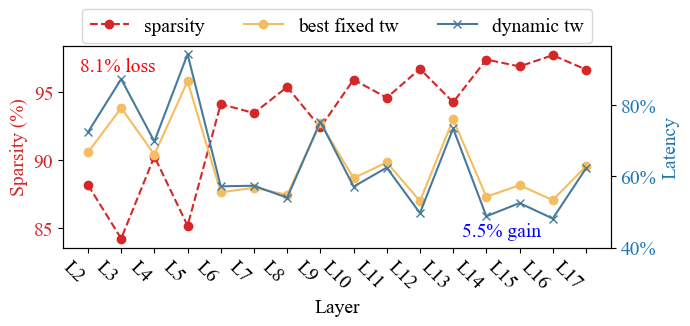

In [97]:
import matplotlib.pyplot as plt
from matplotlib import ticker
color_bar2 = ["#2a9d8f", "#F6BD60", "#457b9d", "#F07167", "#BFA6A2", "#A1CD5A", "#ED7D31"]
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman']
# 假设 eval_res 是之前步骤计算得到的结果列表

# 先按照 layer 排序
eval_res_sorted = sorted(eval_res, key=lambda x: int(x['layer'][1:]))

# 再提取数据
layers = [res['layer'] for res in eval_res_sorted]
sparsities = [res['sparsity']*100 for res in eval_res_sorted]  # sparsity 百分比
latS0_values = [res['latS0'] for res in eval_res_sorted]
latS1_values = [res['latS1'] for res in eval_res_sorted]
latS2_values = [res['latS2'] for res in eval_res_sorted]
latS3_values = [res['latS3'] for res in eval_res_sorted]
latS4_values = [res['latS4'] for res in eval_res_sorted]

# 创建图表
fig, ax1 = plt.subplots(figsize=(7, 3), dpi=100)

# 绘制 sparsity
color = 'tab:red'
ax1.set_xlabel('Layer', fontsize=14)
ax1.set_ylabel('Sparsity (%)', color=color, fontsize=14)
ln1 = ax1.plot(layers, sparsities, marker='o', linestyle='--', color=color, label='sparsity')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(layers, rotation=-45, ha="right", fontsize=14)
# set fontsize for ytick
ax1.tick_params(axis='y', labelsize=14)

# 创建共享 x 轴的第二个 y 轴
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Latency', color=color, fontsize=14)  
# ax2.plot(layers, latS1_values, marker='o', linestyle='-', label='latS1', color='r')
# ax2.plot(layers, latS2_values, marker='x', linestyle='-', label='latS2', color='g')
# ax2.plot(layers, latS3_values, marker='^', linestyle='-', label='latS3', color='b')
# ax2.plot(layers, latS4_values, marker='s', linestyle='-', label='latS4', color='y')
ln2 = plt.plot(layers, [latS1_values[i] / latS0_values[i] for i in range(len(latS0_values))], marker='o', linestyle='-', color=color_bar2[1], label='best fixed tw')
ln3 = plt.plot(layers, [latS2_values[i] / latS0_values[i] for i in range(len(latS0_values))], marker='x', linestyle='-', color=color_bar2[2], label='dynamic tw')
# plt.plot(layers, [latS3_values[i] / latS0_values[i] for i in range(len(latS0_values))], marker='^', linestyle='-', color=color_bar2[3], label='latS3')
# plt.plot(layers, [latS4_values[i] / latS0_values[i] for i in range(len(latS0_values))], marker='s', linestyle='-', color=color_bar2[4], label='latS4')
ax2.tick_params(axis='y', labelcolor=color, labelsize=14)

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

ymin, ymax = ax2.get_ylim()
ax2.set_ylim(0.4, ymax)

fig.tight_layout()  # 调用 tight_layout 来调整子图参数，防止标签重叠
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc="upper center", ncol=3, bbox_to_anchor=(0.50,1.23), fontsize=14)
plt.text(0.1, 0.9, '8.1% loss', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=14, color='r')
plt.text(0.8, 0.08, '5.5% gain', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=14, color='b')
plt.savefig("results/Layer_wise_imagenet_tw_sched.pdf", dpi=100, bbox_inches='tight')
plt.show()

In [89]:
sp1 = [latS1_values[i] / latS0_values[i] for i in range(len(latS0_values))]
sp2 = [latS2_values[i] / latS0_values[i] for i in range(len(latS0_values))]
for i in range(len(sp1)):
    print(f"{(sp2[i] - sp1[i]) * 100:.1f}%")

5.6%
8.1%
3.7%
7.6%
1.7%
0.6%
-0.8%
0.4%
-2.4%
-1.4%
-3.4%
-2.5%
-5.5%
-5.0%
-5.2%
-0.6%


In [81]:
print(eval_res)

[{'file': '../layer_record_IMAGENET/output.L3.conv.plif.csv', 'layer': 'L3', 'sparsity': 0.8422767857142858, 'latS0': 20070400, 'latS1': 15898328, 'latS2': 17523711, 'latS3': 16812828, 'latS4': 17244945}, {'file': '../layer_record_IMAGENET/output.L13.conv.plif.csv', 'layer': 'L13', 'sparsity': 0.9424916294642857, 'latS0': 5017600, 'latS1': 3811583, 'latS2': 3685315, 'latS3': 3489854, 'latS4': 3682701}, {'file': '../layer_record_IMAGENET/output.L16.conv.plif.csv', 'layer': 'L16', 'sparsity': 0.9770551658163266, 'latS0': 2508800, 'latS1': 1339094, 'latS2': 1208551, 'latS3': 1161453, 'latS4': 1265123}, {'file': '../layer_record_IMAGENET/output.L7.conv.plif.csv', 'layer': 'L7', 'sparsity': 0.9344772401147959, 'latS0': 10035200, 'latS1': 5700664, 'latS2': 5758596, 'latS3': 5558184, 'latS4': 5884966}, {'file': '../layer_record_IMAGENET/output.L15.conv.plif.csv', 'layer': 'L15', 'sparsity': 0.9687934470663265, 'latS0': 2508800, 'latS1': 1442556, 'latS2': 1317804, 'latS3': 1261801, 'latS4': 13

In [82]:
with open('results/imagenet_eval_res.json', 'w') as f:
    json.dump(eval_res, f)
# with open('imagenet_eval_res.pkl', 'wb') as f:
#     pickle.dump(eval_res, f)

In [83]:
uniqueLayers = list(eval_res.keys())
uniqueKeys = list(eval_res[uniqueLayers[0]].keys())
with open('results/imagenet_eval_res.csv', 'w') as fr:
    fr.write(',' + ','.join(uniqueKeys) + '\n')
    for layer in uniqueLayers:
        fr.write(layer + "," + ','.join(map(str,list(eval_res[layer].values()))) + '\n')

AttributeError: 'list' object has no attribute 'keys'

### 调度策略可视化

![](https://raw.githubusercontent.com/Senbon-Sakura/Picture/master/202403171620069.png)

# 3. 稀疏编码压缩率分析

In [ ]:
## 方案一：直接编码
storageS1 = dataOut0.size
print(f"storageS1 = {storageS1}")
## 方案二：按时间维度展开的稀疏编码
# dataOut0的维度为[T, H, W]
storageS2CSR = 0
storageS2COO = 0
for ts in range(dataOut0.shape[0]):
    data = dataOut0[ts, :, :]
    data_coo = coo_matrix(data)
    data_csr = csr_matrix(data)
    # 分析coo_matrix的存储结构
    # storageS2COO += data_coo.data.size + data_coo.row.size + data_coo.col.size
    # storageS2CSR += data_csr.data.size + data_csr.indices.size + data_csr.indptr.size
    storageS2COO += ((data_coo.row.size + data_coo.col.size) * 32)
    storageS2CSR += ((data_csr.indices.size + data_csr.indptr.size) * 32)
print(f"storageS2COO = {storageS2COO}, storageS2CSR = {storageS2CSR}")

## 方案三：按空间维度展开的稀疏编码
storageS3CSR = 0
storageS3COO = 0
for h in range(dataOut0.shape[1]):
    data = dataOut0[:, h, :]
    data_coo = coo_matrix(data)
    data_csr = csr_matrix(data)
    storageS3COO += ((data_coo.row.size + data_coo.col.size) * 32)
    storageS3CSR += ((data_csr.indices.size + data_csr.indptr.size) * 32)
print(f"storageS3COO = {storageS3COO}, storageS3CSR = {storageS3CSR}")

## 时间维度pack的稀疏方式

In [2]:
def pack_bits_per_row(matrix, N):
    packed_matrix = []
    for row in matrix:
        packed_row = []
        for i in range(0, len(row), N):
            # 对于每N个位，将它们打包成一个数
            chunk = row[i:i+N]
            byte = 0
            for bit in chunk:
                byte = (byte << 1) | bit
            packed_row.append(byte)
        packed_matrix.append(packed_row)
    return np.array(packed_matrix, dtype=np.int32)

In [21]:
def compress_ratio(fname):
    # dataOut0 = LoadInSnnOutputData("../layer_record_CIFAR10DVS/output.L3.conv.plif.csv", 0, 100, 100, unmerge=True)
    dataOut0 = LoadInSnnOutputData(fname, 0, 100, 100, unmerge=True)
    sparsity = np.sum(dataOut0 == 0) / dataOut0.size
    print(f"Bit sparsity: {sparsity * 100:.2f}%")
    # print(f"original storage: {dataOut0.size / (2 ** 23):2f} MB")
    # print(dataOut0.shape)
    # T, (H*W), Cout => (H*W), Cout, T => (H*W)*Cout, T
    data = np.transpose(dataOut0, (1, 2, 0)).reshape(-1, dataOut0.shape[0]).astype(bool)
    # 按行进行pack
    data_p8 = pack_bits_per_row(data, 8)
    # print(np.sum(data_p8 == 0) / data_p8.size)
    # data_p16 = pack_bits_per_row(data, 16)
    # print(np.sum(data_p16 == 0) / data_p16.size)
    # data_p32 = pack_bits_per_row(data, 32)
    # print(np.sum(data_p32 == 0) / data_p32.size)
    # print(data_p32.shape)
    # data_p64 = pack_bits_per_row(data, 64)
    # print(np.sum(data_p64 == 0) / data_p64.size)
    '''
    p8:  0.6726768200214093
    p16: 0.6045186179024833
    p32: 0.560086727142334
    p64: 0.44948482513427734
    '''
    data_pack = data_p8
    data_csr = csr_matrix(data_pack, dtype=np.int32)
    ori_storage = data_pack.nbytes
    csr_storage = data_csr.indices.nbytes + data_csr.indptr.nbytes / 2 + data_csr.data.nbytes / 4
    # print(f'{data_csr.indices.nbytes=}, {data_csr.indptr.nbytes=}, {data_csr.data.nbytes=}')
    # print(f"{csr_storage=}")
    # print(f"ori_storage = {ori_storage / (2 ** 20):2f} MB, csr_storage = {csr_storage / (2 ** 20):2f} MB")
    print(f"compression ratio = {csr_storage / ori_storage * 100:.2f} %")
    return sparsity, 1 - csr_storage / ori_storage

In [22]:
from collections import defaultdict
# 遍历文件夹"../layer_record_IMAGENET/"
layer_record_dir = "../layer_record_IMAGENET/"
compress_ratio_dict = defaultdict(dict)
pat = r"output.(L[0-9]+).conv.plif.csv"
for file in os.listdir(layer_record_dir):
    res = re.findall(pat, file)
    if len(res) and res[0] != "L1":
        print(f"file = {os.path.join(layer_record_dir, file)}")
        sparsity, compress_rate = compress_ratio(os.path.join(layer_record_dir, file))
        compress_ratio_dict[res[0]]['sparsity'] = sparsity
        compress_ratio_dict[res[0]]['compress_rate'] = compress_rate

with open('results/imagenet_compress_ratio.json', 'w') as f:
    json.dump(compress_ratio_dict, f)

file = ../layer_record_IMAGENET/output.L3.conv.plif.csv
Bit sparsity: 84.23%
compression ratio = 73.40 %
file = ../layer_record_IMAGENET/output.L13.conv.plif.csv
Bit sparsity: 94.25%
compression ratio = 47.34 %
file = ../layer_record_IMAGENET/output.L16.conv.plif.csv
Bit sparsity: 97.71%
compression ratio = 24.44 %
file = ../layer_record_IMAGENET/output.L7.conv.plif.csv
Bit sparsity: 93.45%
compression ratio = 41.30 %
file = ../layer_record_IMAGENET/output.L15.conv.plif.csv
Bit sparsity: 96.88%
compression ratio = 29.26 %
file = ../layer_record_IMAGENET/output.L8.conv.plif.csv
Bit sparsity: 95.37%
compression ratio = 36.42 %
file = ../layer_record_IMAGENET/output.L10.conv.plif.csv
Bit sparsity: 95.90%
compression ratio = 36.26 %
file = ../layer_record_IMAGENET/output.L2.conv.plif.csv
Bit sparsity: 88.17%
compression ratio = 58.94 %
file = ../layer_record_IMAGENET/output.L11.conv.plif.csv
Bit sparsity: 94.58%
compression ratio = 41.94 %
file = ../layer_record_IMAGENET/output.L4.conv.pli

In [23]:
from bz2 import compress


with open('results/imagenet_compress_ratio.json', 'r') as f:
    compress_ratio_dict = json.load(f)
compress_ratio_dict

{'L3': {'sparsity': 0.8422767857142858, 'compress_rate': 0.2659674484276884},
 'L13': {'sparsity': 0.9424916294642857, 'compress_rate': 0.5266109448587127},
 'L16': {'sparsity': 0.9770551658163266, 'compress_rate': 0.7556309482927787},
 'L7': {'sparsity': 0.9344772401147959, 'compress_rate': 0.5870275093210361},
 'L15': {'sparsity': 0.9687934470663265, 'compress_rate': 0.7074122166895604},
 'L8': {'sparsity': 0.9536576251594387, 'compress_rate': 0.6357598177492151},
 'L10': {'sparsity': 0.9590441645408163, 'compress_rate': 0.6374189775068682},
 'L2': {'sparsity': 0.8816662846779336, 'compress_rate': 0.410596335514374},
 'L11': {'sparsity': 0.9457756696428572, 'compress_rate': 0.5806112484056123},
 'L4': {'sparsity': 0.9025780751753827, 'compress_rate': 0.45567276264472134},
 'L17': {'sparsity': 0.9664660395408163, 'compress_rate': 0.6753251631181318},
 'L12': {'sparsity': 0.967008131377551, 'compress_rate': 0.6985729463059263},
 'L5': {'sparsity': 0.8517442602040817, 'compress_rate': 0

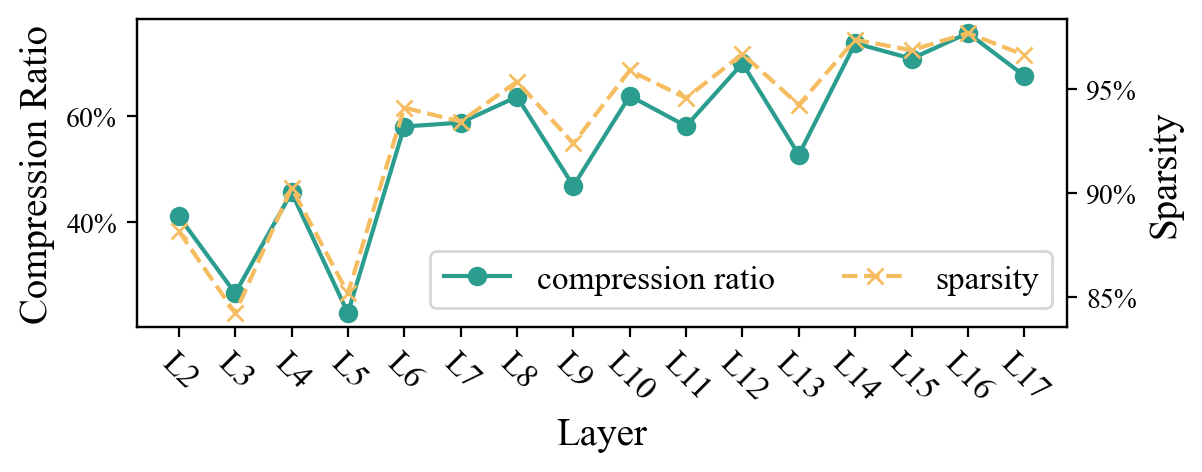

In [46]:

from cProfile import label
import matplotlib.pyplot as plt
from matplotlib import ticker
color_bar2 = ["#2a9d8f", "#F6BD60", "#457b9d", "#F07167", "#BFA6A2", "#A1CD5A", "#ED7D31"]
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman']

unique_layers = sorted(list(compress_ratio_dict.keys()), key=lambda x: int(x[1:]))
sparsity_values = [compress_ratio_dict[layer]['sparsity'] for layer in unique_layers]
compress_ratio_values = [compress_ratio_dict[layer]['compress_rate'] for layer in unique_layers]
fig, ax = plt.subplots(figsize=(6, 2), dpi=200)
ln1 = plt.plot(unique_layers, compress_ratio_values, marker='o', linestyle='-', color=color_bar2[0], label='compression ratio')
plt.xticks(rotation=-45, fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Compression Ratio", fontsize=14)
plt.twinx()
ln2 = plt.plot(unique_layers, sparsity_values, marker='x', linestyle='--', color=color_bar2[1], label='sparsity')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.ylabel("Sparsity", fontsize=14)
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc="upper center", ncol=2, bbox_to_anchor=(0.65,0.30), fontsize=12)
plt.savefig("results/Layer_wise_imagenet_compress_ratio.pdf", dpi=100, bbox_inches='tight')

In [12]:
layer_record_dir = "../layer_record_DVS128Gesture"
for file in os.listdir(layer_record_dir):
    print(f"file = {os.path.join(layer_record_dir, file)}")
    compress_ratio(os.path.join(layer_record_dir, file))



file = ../layer_record_DVS128Gesture/output.L3.conv.plif.csv
Bit sparsity: 96.46%
compression ratio = 36.25 %
file = ../layer_record_DVS128Gesture/input.L3.conv.conv2d.csv
Bit sparsity: 97.74%
compression ratio = 23.55 %
file = ../layer_record_DVS128Gesture/weight.L1.conv.conv2d.csv


ValueError: cannot reshape array of size 2304 into shape (100,newaxis,128)